# Importing Necessary Packages

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import string

from sklearn.model_selection import GridSearchCV
from collections import Counter
import seaborn as sns
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM, Embedding, Dense, Flatten, Dropout
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Loading Data

In [2]:
pharmatrain = pd.read_csv('C:/Users/kgpr/OneDrive/Desktop/train.csv')

In [3]:
pharmatest = pd.read_csv('C:/Users/kgpr/OneDrive/Desktop/test.csv')

In [4]:
pharmatrain.shape, pharmatest.shape

((5279, 4), (2924, 3))

In [5]:
pharmatrain.head()

unique_hash  \
0  2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0   
1  9eba8f80e7e20f3a2f48685530748fbfa95943e4   
2  fe809672251f6bd0d986e00380f48d047c7e7b76   
3  bd22104dfa9ec80db4099523e03fae7a52735eb6   
4  b227688381f9b25e5b65109dd00f7f895e838249   

                                                text        drug  sentiment  
0  Autoimmune diseases tend to come in clusters. ...     gilenya          2  
1  I can completely understand why you’d want to ...     gilenya          2  
2  Interesting that it only targets S1P-1/5 recep...  fingolimod          2  
3  Very interesting, grand merci. Now I wonder wh...     ocrevus          2  
4  Hi everybody, My latest MRI results for Brain ...     gilenya          1

In [6]:
pharmatest.head()

unique_hash  \
0  9e9a8166b84114aca147bf409f6f956635034c08   
1  e747e6822c867571afe7b907b51f0f2ca67b0e1a   
2  50b6d851bcff4f35afe354937949e9948975adf7   
3  7f82ec2176ae6ab0b5d20b5ffc767ac829f384ae   
4  8b37d169dee5bdae27060949242fb54feb6a7f7f   

                                                text        drug  
0  256 (previously stable on natalizumab), with 5...  fingolimod  
1  On fingolimod and have been since December 201...  fingolimod  
2  Apparently it's shingles! :-/ I do have a few ...      humira  
3  If the Docetaxel doing once a week x3 weeks th...    tagrisso  
4  CC, Stelara worked in a matter of days for me....     stelara

# Data Exploration

In [7]:
# Frequency of drug Classes Present
pd.value_counts(pharmatrain['drug'])

ocrevus                         676
gilenya                         666
ocrelizumab                     441
entyvio                         303
humira                          270
fingolimod                      238
remicade                        229
opdivo                          224
tarceva                         218
cladribine                      200
keytruda                        199
stelara                         161
tagrisso                        161
alimta                          146
lucentis                         67
eylea                            65
avastin                          52
nivolumab                        50
cimzia                           48
alectinib                        43
crizotinib                       43
vitrectomy                       41
simponi                          39
erlotinib                        35
tecentriq                        34
pemetrexed                       33
xalkori                          33
tysabri                     

In [8]:
# Frequency of sentiments Present
pd.value_counts(pharmatrain['sentiment'])

2    3825
1     837
0     617
Name: sentiment, dtype: int64

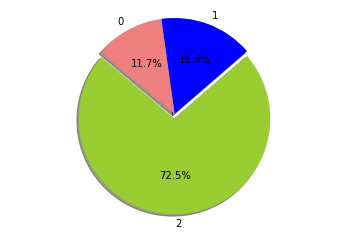

In [9]:
labels = 2, 1, 0
sizes = [pd.value_counts(pharmatrain['sentiment'])[2], pd.value_counts(pharmatrain['sentiment'])[1], pd.value_counts(pharmatrain['sentiment'])[0]]
colors = ['yellowgreen', 'blue', 'lightcoral']
explode = (0.05, 0, 0)  


plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

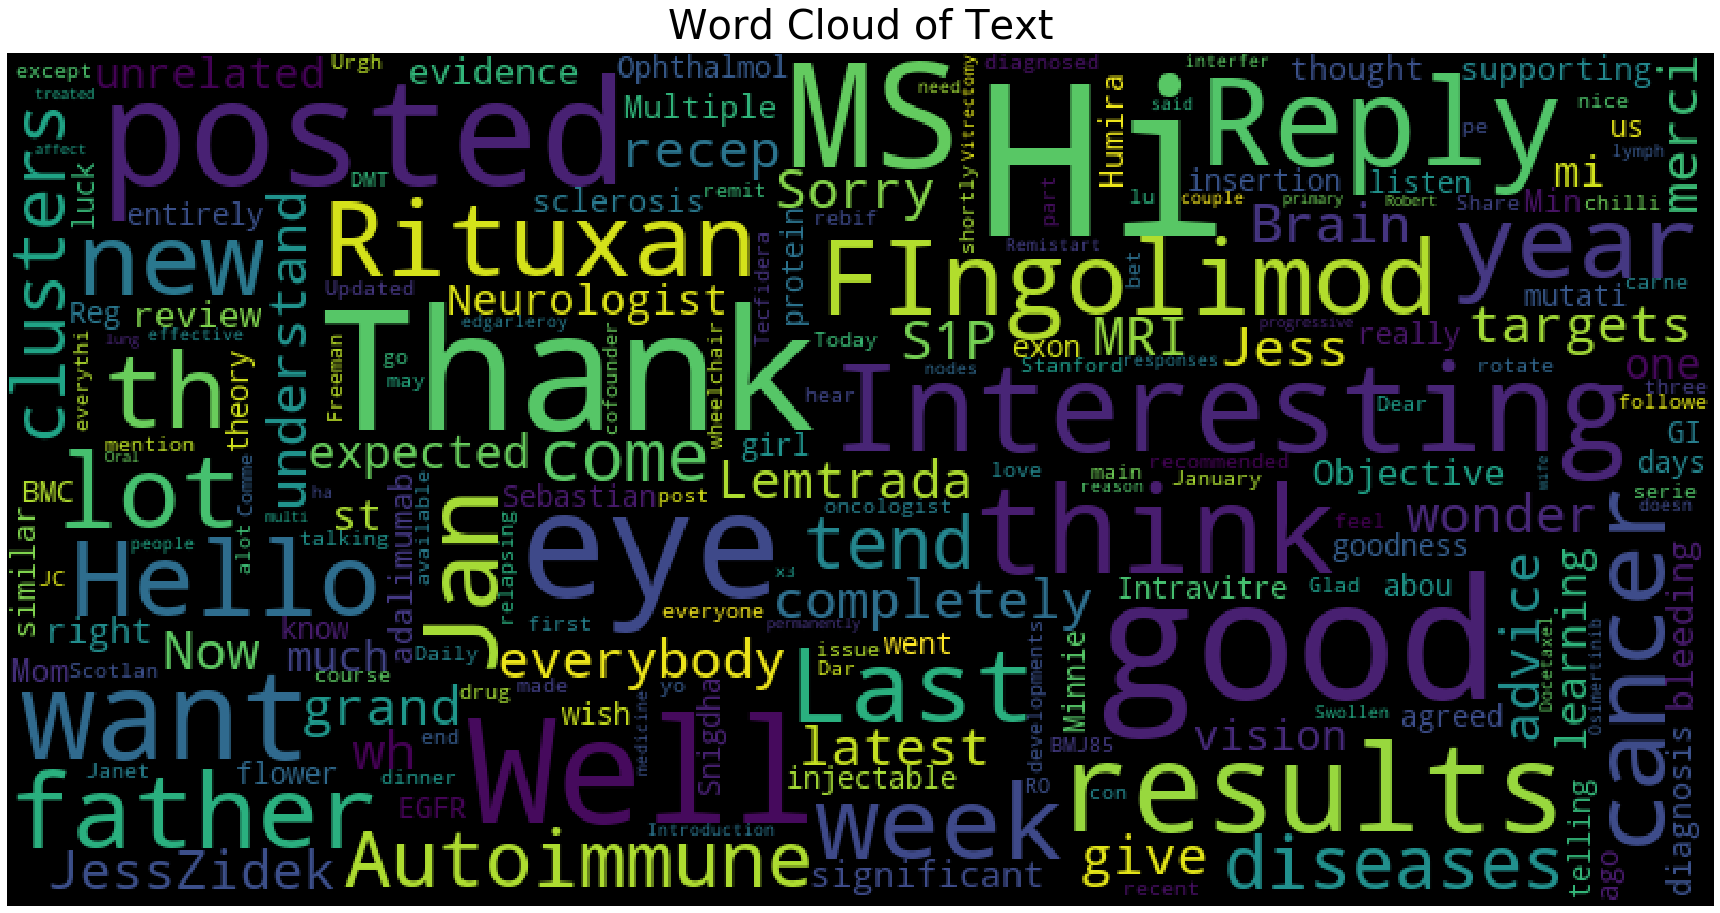

In [10]:
def wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
wordcloud(pharmatrain["text"], title="Word Cloud of Text")

In [11]:
import plotly.express as px

drugCounts = pharmatrain['drug'].value_counts()
values = drugCounts.keys().tolist()
counts = drugCounts.tolist()
drugCounts = pd.DataFrame({'values': values, 'counts': counts})

fig = px.bar(drugCounts, x='values', y='counts')
fig.show()

for k, v in drugCounts.items():
    if "well" in k.lower():
        print(k, v)

# N-gram Visualisation

In [12]:
pharmatrain_2 = pharmatrain[pharmatrain["sentiment"]==2]
pharmatrain_1 = pharmatrain[pharmatrain["sentiment"]==1]
pharmatrain_0 = pharmatrain[pharmatrain["sentiment"]==0]


In [13]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

In [14]:
freq_dict = defaultdict(int)
for row in pharmatrain["text"]:
    for word in generate_ngrams(row):
        freq_dict[word] += 1
dict_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
dict_sorted.columns = ["word", "wordcount"]

Text(0, 0.5, 'Top Frequent Words')

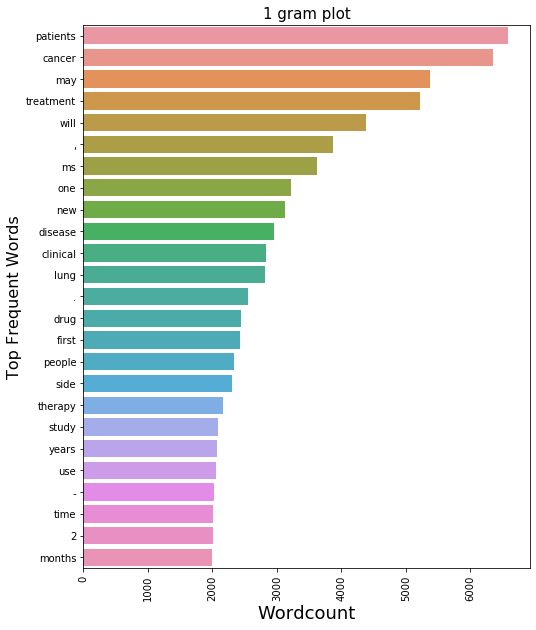

In [15]:
plt.figure(figsize = (8, 10))
g = sns.barplot(x = 'wordcount', y = 'word', data = dict_sorted.iloc[:25])
plt.xticks(rotation=90)
plt.title('1 gram plot', fontsize=15)
plt.xlabel('Wordcount', fontsize=18)
plt.ylabel('Top Frequent Words', fontsize=16)

In [16]:
freq_dict = defaultdict(int)
for row in pharmatrain["text"]:
    for word in generate_ngrams(row, 2):
        freq_dict[word] += 1
dict_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
dict_sorted.columns = ["word", "wordcount"]

Text(0, 0.5, 'Wordcount')

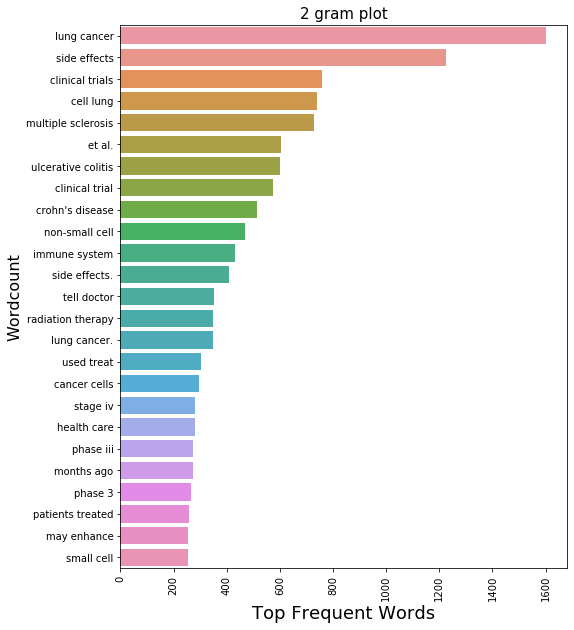

In [18]:
plt.figure(figsize = (8, 10))
g = sns.barplot(x = 'wordcount', y = 'word', data = dict_sorted.iloc[:25])
plt.xticks(rotation=90)
plt.title('2 gram plot', fontsize=15)
plt.xlabel('Top Frequent Words', fontsize=18)
plt.ylabel('Wordcount', fontsize=16)

# Data Cleaning

In [19]:
pharmatrain["text"] = pharmatrain['text'].str.replace('[^\w\s]','') # Removing Punctuations
pharmatrain['text'] = pharmatrain['text'].apply(lambda x: x.lower()) # Making Text Lowercase
stop = stopwords.words('english')  # Removing Stopwords
pharmatrain['text'] = pharmatrain['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
# Stemming
pharmatrain['text'] = pharmatrain["text"].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

In [20]:
pharmatest["text"] = pharmatest['text'].str.replace('[^\w\s]','') # Removing Punctuations
pharmatest['text'] = pharmatest['text'].apply(lambda x: x.lower()) # Making Text Lowercase
# Removing Stopwords
pharmatest['text'] = pharmatest['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
# Stemming
pharmatest['text'] = pharmatest["text"].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

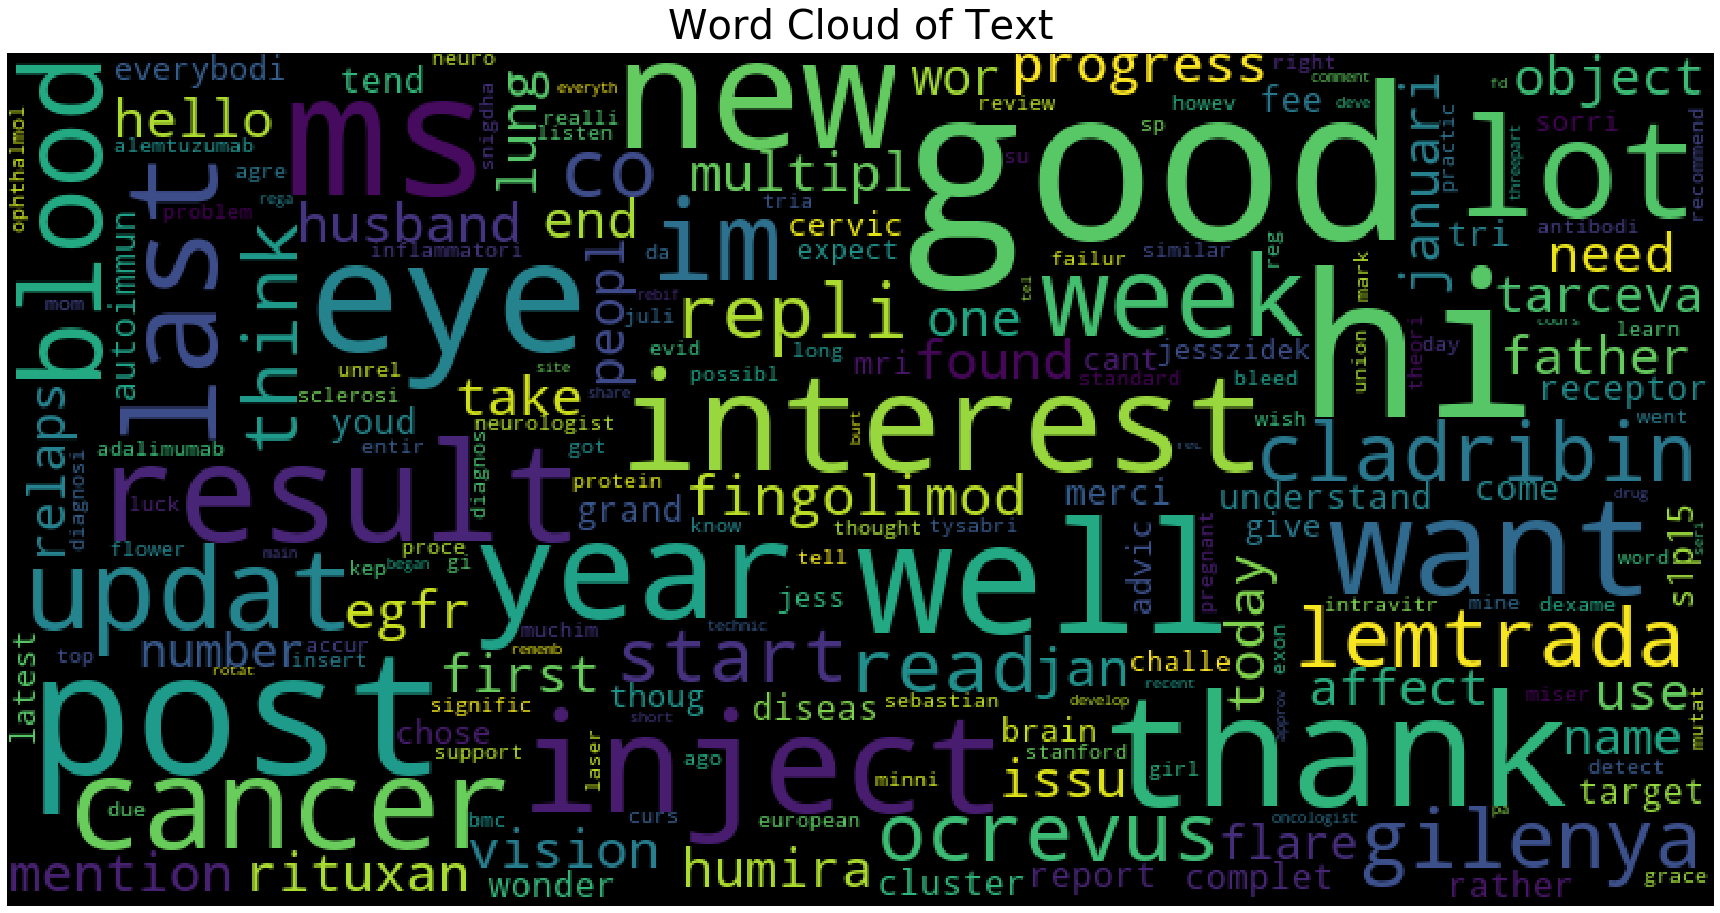

In [21]:
  
wordcloud(pharmatrain["text"], title="Word Cloud of Text")

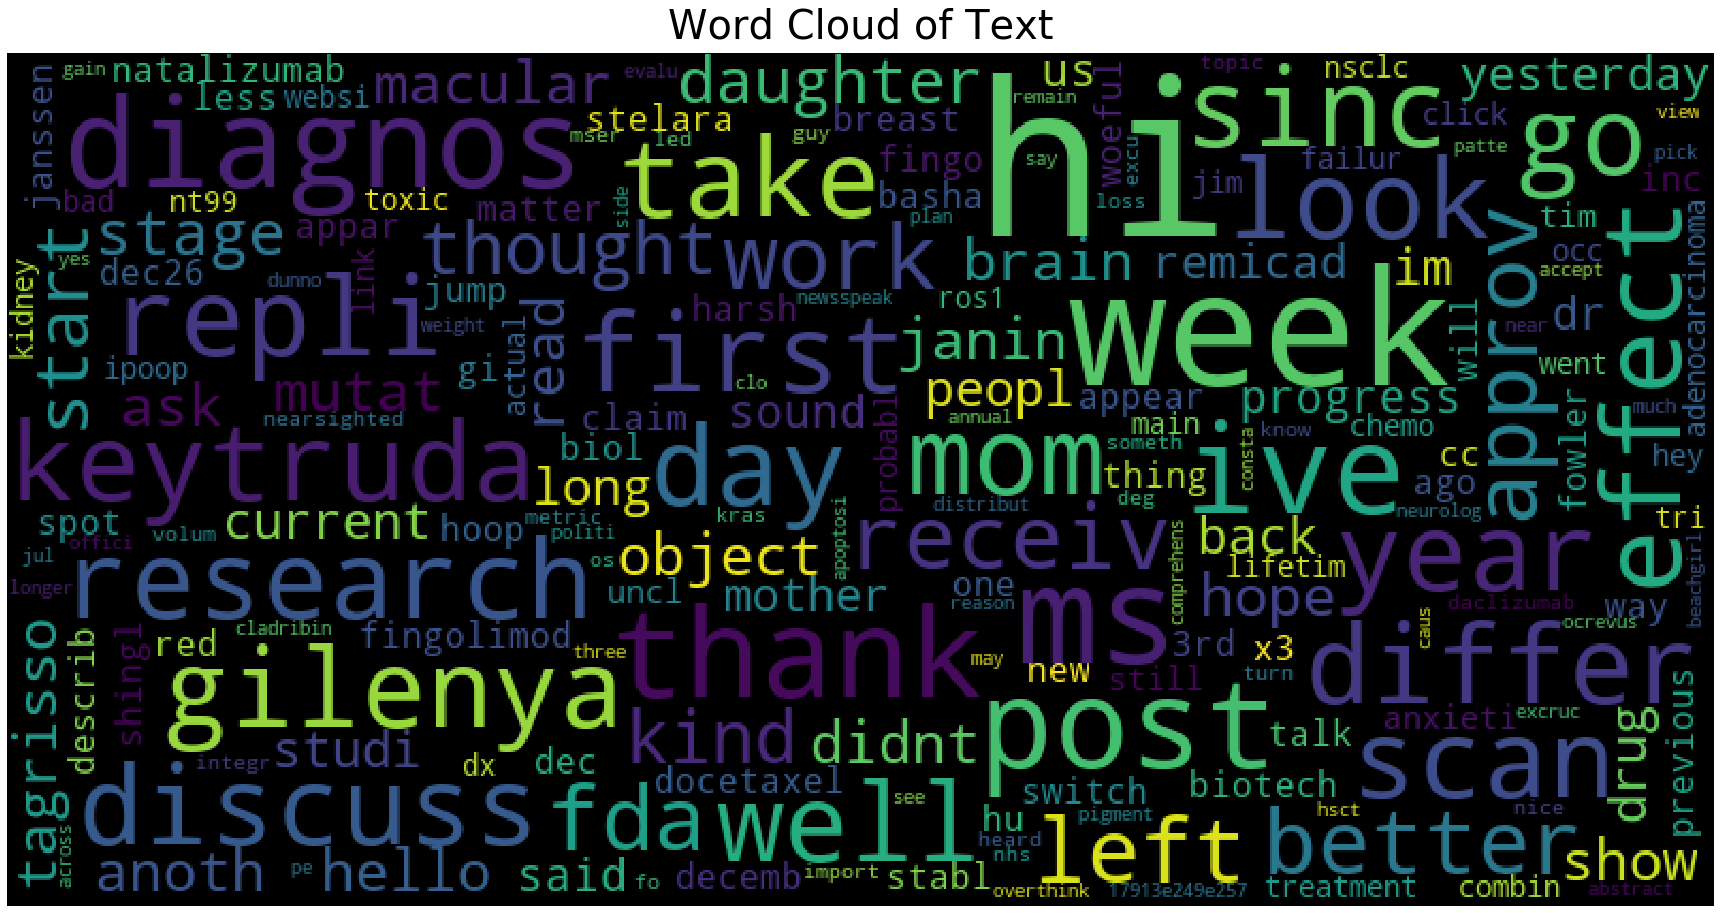

In [22]:
wordcloud(pharmatest["text"], title="Word Cloud of Text")

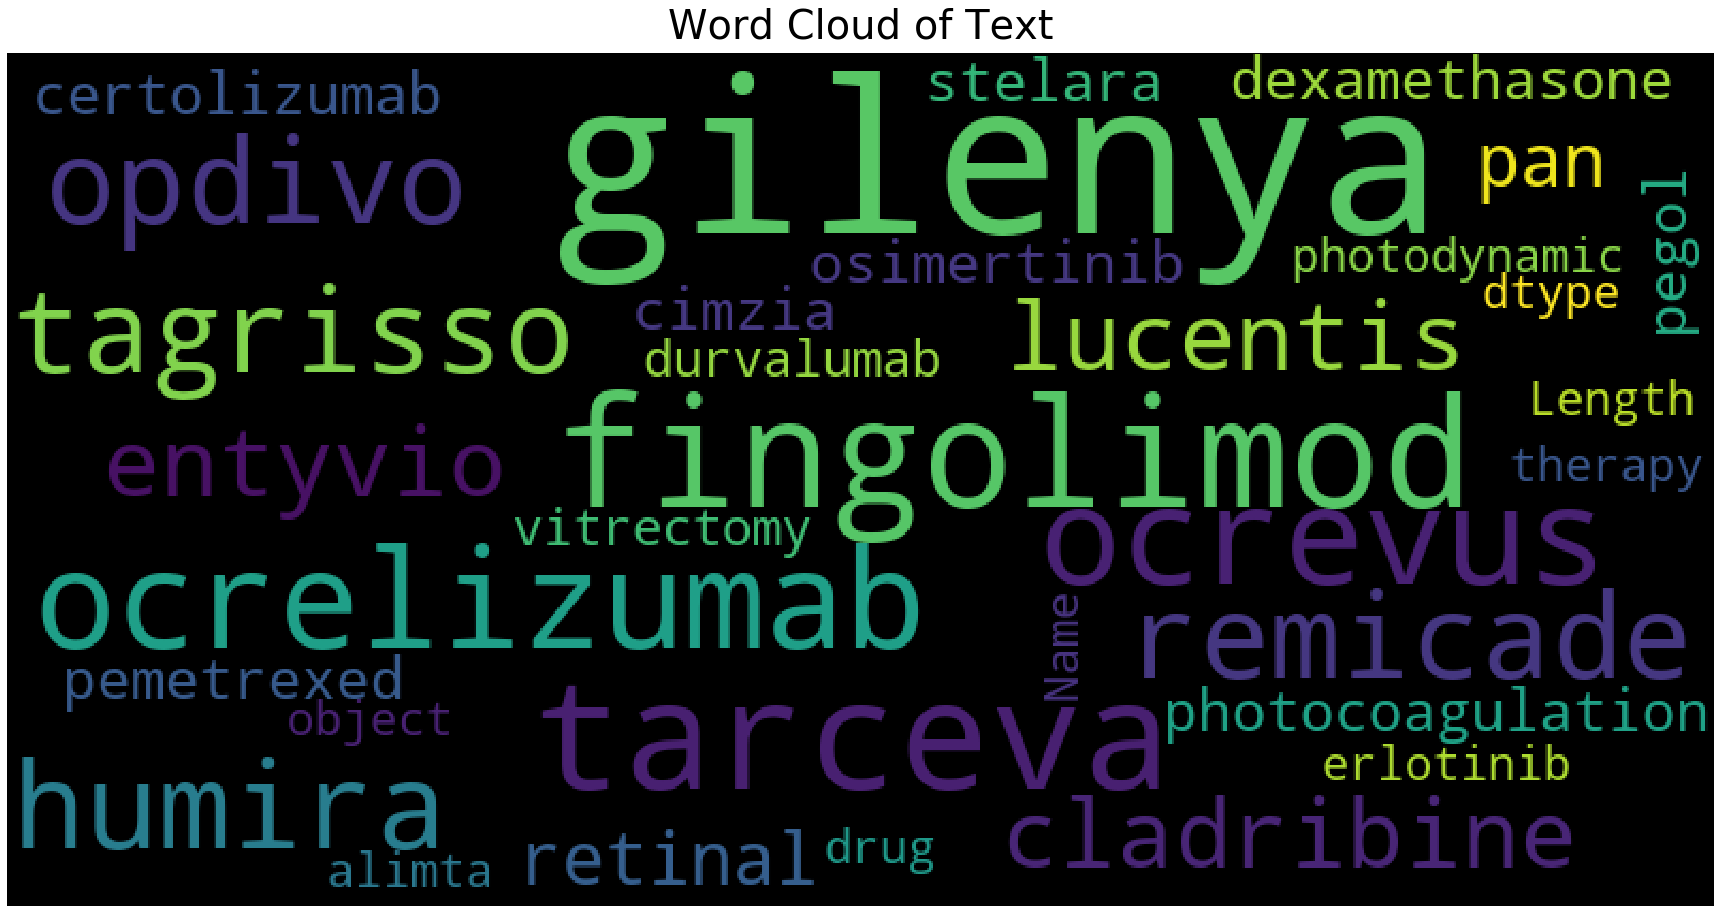

In [23]:
wordcloud(pharmatrain["drug"], title="Word Cloud of Text")

## Vader Sentiment

In [24]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [27]:
listy = []

for index, row in pharmatrain.iterrows():
  ss = analyser.polarity_scores(row["text"])
  listy.append(ss) 
  
se = pd.Series(listy)
pharmatrain['polarity'] = se.values

pharmatrain.head()

unique_hash  \
0  2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0   
1  9eba8f80e7e20f3a2f48685530748fbfa95943e4   
2  fe809672251f6bd0d986e00380f48d047c7e7b76   
3  bd22104dfa9ec80db4099523e03fae7a52735eb6   
4  b227688381f9b25e5b65109dd00f7f895e838249   

                                                text        drug  sentiment  \
0  autoimmun diseas tend come cluster gilenya fee...     gilenya          2   
1  complet understand youd want tri result report...     gilenya          2   
2  interest target s1p15 receptor rather 15 like ...  fingolimod          2   
3  interest grand merci wonder lemtrada ocrevus s...     ocrevus          2   
4  hi everybodi latest mri result brain cervic co...     gilenya          1   

                                            polarity  
0  {'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'comp...  
1  {'neg': 0.052, 'neu': 0.848, 'pos': 0.1, 'comp...  
2  {'neg': 0.04, 'neu': 0.752, 'pos': 0.208, 'com...  
3  {'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'comp...  
4  {'neg': 0.036, 'neu': 0.827, 'pos': 0.137, 'co...

# Feature Selection

In [28]:
# Selecting top 2000 frequent; The number of frequent words words has been choosen after data analysis
freq_words = [key for (key, count) in Counter(" ".join(pharmatrain["text"]).split()).most_common(2000)]
pharmatrain['text'] = pharmatrain["text"].apply(lambda x: ' '.join([word for word in x.split() if word in freq_words]))

## Creating Bag of Words Model

In [29]:
count = CountVectorizer()
bag_of_words = count.fit_transform(pharmatrain['text'].values)
X_train = bag_of_words.toarray()
y_train = pharmatrain['drug']
X_test = count.fit_transform(pharmatrain['text'].values).toarray()
y_test= pharmatest['drug']

In [30]:
clf = RandomForestClassifier(
                         #   max_features='sqrt', 
                            #oob_score=True,
                            n_jobs=-1,
                            random_state=42
                            )
param_grid = {
                 'n_estimators': [200, 500],
                 'max_depth': [5, 10, 15]
             }
rf_clf = GridSearchCV(clf, param_grid, cv=5) # cv = 5 specifies the number of folds in a (Stratified)KFold.
rf_clf.fit(X_train, y_train)

C:\Users\kgpr\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                    

In [31]:
best_parameters = rf_clf.best_params_  
print(best_parameters)  

{'max_depth': 15, 'n_estimators': 500}


In [32]:
predictions = rf_clf.best_estimator_.predict(X_test)

In [34]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=50)  # Number if n_components is a parameter to be tuned.
X_train_lda = lda.fit_transform(X_train, y_train)  
X_test_lda = lda.transform(X_test)

In [35]:
lda_clf = RandomForestClassifier()
param_grid = {
                 'n_estimators': [5, 10, 15],
                 'max_depth': [2, 5, 7]
             }
lda_rf_clf = GridSearchCV(lda_clf, param_grid, cv=5) # cv = 5 specifies the number of folds in a (Stratified)KFold.
lda_rf_clf.fit(X_train_lda, y_train)

C:\Users\kgpr\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [36]:
best_parameters = lda_rf_clf.best_params_  
print(best_parameters)  

{'max_depth': 7, 'n_estimators': 15}


In [37]:
predictions1 = rf_clf.best_estimator_.predict(X_test)

# Deep Learning

## One hot encoding

In [39]:
label = LabelEncoder()
la_labels = label.fit_transform(y_train)
one_hot = OneHotEncoder(sparse=False)
reshaped_la_labels = la_labels.reshape((len(la_labels), 1))
target = one_hot.fit_transform(reshaped_la_labels)

In [40]:
token = Tokenizer(num_words=2000) # Again selecting 2000 features
token.fit_on_texts(pharmatrain['text'].values)
train_embeddings = token.texts_to_sequences(pharmatrain['text'].values)
test_embeddings = token.texts_to_sequences(pharmatest['text'].values)
vocab_size = len(token.word_index) + 1

In [41]:
max_len = 20
embedded_train = pad_sequences(train_embeddings, padding='post', maxlen=max_len)
embedded_test = pad_sequences(test_embeddings, padding='post', maxlen=max_len)

In [45]:
embedding_dim = 25

model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=max_len))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(102, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 25)            50025     
_________________________________________________________________
flatten_2 (Flatten)          (None, 500)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5010      
_________________________________________________________________
dense_4 (Dense)              (None, 102)               1122      
Total params: 56,157
Trainable params: 56,157
Non-trainable params: 0
_________________________________________________________________


In [46]:
x_train, x_test, y_tr, y_te = train_test_split(embedded_train, target, random_state = 42)


In [47]:
log_record = model.fit(x_train, y_tr,
                    epochs=25,
                    validation_data=(x_test, y_te),
                    batch_size=16)

Train on 3959 samples, validate on 1320 samples
Epoch 1/25
3959/3959 [==============================] - 1s 160us/step - loss: 3.9515 - accuracy: 0.1212 - val_loss: 3.2103 - val_accuracy: 0.1295
Epoch 2/25
3959/3959 [==============================] - 1s 158us/step - loss: 3.0696 - accuracy: 0.1394 - val_loss: 3.0566 - val_accuracy: 0.1530
Epoch 3/25
3959/3959 [==============================] - 1s 178us/step - loss: 2.8046 - accuracy: 0.2187 - val_loss: 2.8347 - val_accuracy: 0.2568
Epoch 4/25
3959/3959 [==============================] - 1s 166us/step - loss: 2.4187 - accuracy: 0.3524 - val_loss: 2.6000 - val_accuracy: 0.3152
Epoch 5/25
3959/3959 [==============================] - 1s 128us/step - loss: 2.0639 - accuracy: 0.4569 - val_loss: 2.4498 - val_accuracy: 0.3621
Epoch 6/25
3959/3959 [==============================] - 1s 137us/step - loss: 1.7816 - accuracy: 0.5421 - val_loss: 2.3837 - val_accuracy: 0.3939
Epoch 7/25
3959/3959 [==============================] - 1s 203us/step - loss

In [48]:
loss, accuracy = model.evaluate(x_train, y_tr)
print("Training Accuracy: {:.6f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_te)
print("Testing Accuracy:  {:.6f}".format(accuracy))

3959/3959 [==============================] - 0s 28us/step
Training Accuracy: 0.924981
1320/1320 [==============================] - 0s 42us/step
Testing Accuracy:  0.398485


In [49]:
predictions_fc = np.argmax(model.predict(embedded_test), axis = 1)

In [50]:
def visualise_log_record(log_record):
    train_accuracy = log_record.history['accuracy']
    validation_accuracy = log_record.history['val_accuracy']
    train_loss = log_record.history['loss']
    validation_loss = log_record.history['val_loss']
    x = range(1, len(train_accuracy) + 1)

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x, train_accuracy, 'b', label='Training Accuracy')
    plt.plot(x, validation_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, train_loss, 'b', label='Training Loss')
    plt.plot(x, validation_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend(loc = 'best')

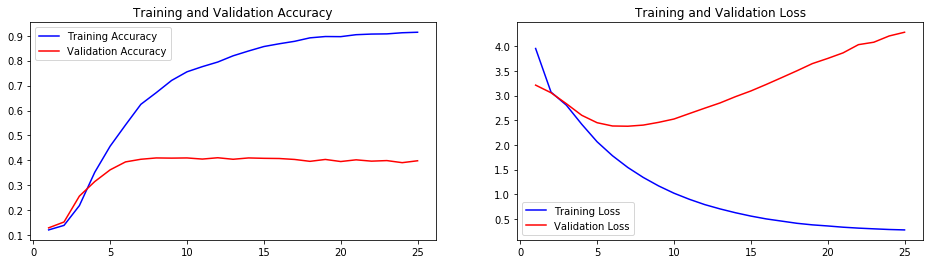

In [51]:
visualise_log_record(log_record)


## LSTM

RNNs are family of neural networks used for processing sequential data. However, simple RNNs are not able to capture the long term dependencies which is a major bottleneck.

LSTM(Long Short Term Memory) is an artificial neural network model which are composed of self loops capable of storing long term dependencies.


In [52]:
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=max_len)
         )
model.add(LSTM(64))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.55))
model.add(Dense(102, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 25)            50025     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                23040     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 102)               6630      
Total params: 83,855
Trainable params: 83,855
Non-trainable params: 0
_________________________________________________________________


In [53]:
log_record = model.fit(x_train, y_tr,
                    epochs=15,
                    validation_data=(x_test, y_te),
                    batch_size=16)

Train on 3959 samples, validate on 1320 samples
Epoch 1/15
3959/3959 [==============================] - 4s 965us/step - loss: 3.5940 - accuracy: 0.1129 - val_loss: 3.1317 - val_accuracy: 0.1295
Epoch 2/15
3959/3959 [==============================] - 3s 806us/step - loss: 3.1338 - accuracy: 0.1313 - val_loss: 2.9284 - val_accuracy: 0.1470
Epoch 3/15
3959/3959 [==============================] - 3s 818us/step - loss: 2.8013 - accuracy: 0.1720 - val_loss: 2.7592 - val_accuracy: 0.1932
Epoch 4/15
3959/3959 [==============================] - 3s 824us/step - loss: 2.5243 - accuracy: 0.2091 - val_loss: 2.5912 - val_accuracy: 0.2114
Epoch 5/15
3959/3959 [==============================] - 4s 904us/step - loss: 2.2876 - accuracy: 0.2589 - val_loss: 2.5464 - val_accuracy: 0.2523
Epoch 6/15
3959/3959 [==============================] - 3s 819us/step - loss: 2.1599 - accuracy: 0.2872 - val_loss: 2.6261 - val_accuracy: 0.2561
Epoch 7/15
3959/3959 [==============================] - 4s 905us/step - loss

In [54]:
loss, accuracy = model.evaluate(x_train, y_tr)
print("Training Accuracy: {:.6f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_te)
print("Testing Accuracy:  {:.6f}".format(accuracy))

3959/3959 [==============================] - 1s 159us/step
Training Accuracy: 0.564031
1320/1320 [==============================] - 0s 132us/step
Testing Accuracy:  0.387879


In [55]:
predictions_lstm = np.argmax(model.predict(embedded_test), axis = 1)

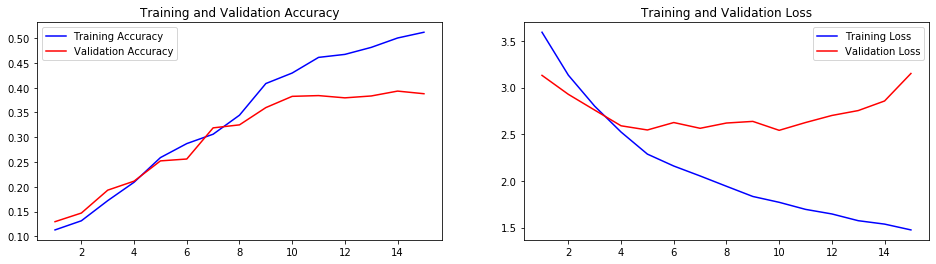

In [56]:
visualise_log_record(log_record)